In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import random

import gym
from tqdm import tqdm
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns

In [137]:
policy_lrs = [1e-2, 3e-3, 5e-3, 4e-4, 9e-4]
state_val_lr = 0.009
gamma = 0.99
num_episodes = 1250
max_steps = 1000
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [31]:
class Policy(nn.Module):
  def __init__(self, input_size, output_size, seed):
    super().__init__()

    self.seed = torch.manual_seed(seed)
    self.model = nn.Sequential(
        nn.Linear(input_size, 150),
        nn.LeakyReLU(),
        # nn.Linear(64, 32),
        # nn.LeakyReLU(),
        nn.Linear(150, output_size),
        nn.Softmax(dim = 1)
    )


  def forward(self, x):
    return self.model(x)

In [32]:
class State_val(nn.Module):
  def __init__(self, input_size, seed):
    super().__init__()

    self.seed = torch.manual_seed(seed)
    self.model = nn.Sequential(
        nn.Linear(input_size, 150),
        nn.LeakyReLU(),
        # nn.Linear(64, 32),
        # nn.LeakyReLU(),
        nn.Linear(150, 1),
        nn.Softmax(dim = 1)
    )

  def forward(self, x):
    return self.model(x)

In [33]:
def choose_action(model, state):

  #convert state to float tensor, add 1 dimension, allocate tensor on device
  state = torch.from_numpy(state).float().unsqueeze(0).to(device)
  state = state.detach()
  action_prob = model(state)
  m = Categorical(action_prob)
  action = m.sample()

  # log p(a∣π(s))
  log_p = m.log_prob(action)

  return action.item(), log_p


In [34]:
def calculate_rewards(rewards):
  G_episode = []

  G_cumulative = 0

  for r in reversed(rewards):
    G_cumulative = r + gamma*G_cumulative
    G_episode.append(G_cumulative)

  rewards = torch.tensor(G_episode).to(device)
  rewards = torch.flip(rewards, [0])

  rewards = (rewards - rewards.mean())/rewards.std()

  return rewards


In [35]:
def train_policy(rewards, log_probs, policy_optimizer):
  policy_loss = []

  for r, log_p in zip(rewards, log_probs):
    policy_loss.append(-r*log_p)

  policy_optimizer.zero_grad()
  sum(policy_loss).backward()
  policy_optimizer.step()



In [36]:
def train_state_val(G_trajectory, state_values, state_val_optimizer):
  state_val_loss = F.mse_loss(state_values, G_trajectory)

  state_val_optimizer.zero_grad()
  state_val_loss.backward()
  state_val_optimizer.step()


In [37]:
env = gym.make('CartPole-v1')
seed = 42
env.seed(seed)

/Library/anaconda3/envs/torch/lib/python3.11/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Library/anaconda3/envs/torch/lib/python3.11/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Library/anaconda3/envs/torch/lib/python3.11/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


[42]

In [38]:
# state = env.reset()
# choose_action(PolicyNetwork, state)

In [85]:
def regret(r):
  regrets = []
  for i in r:
    max_r = max(i)
    reg = np.sum(np.array(max_r)-np.array(i))
    regrets.append(reg)
  return regrets

In [54]:
def plot_f(reward_avgs, msg = 'Reward Curve'):
  fig, ax = plt.subplots(figsize=(7, 7))
  #plt.figure(figsize=(15,15))
  fig.suptitle(msg ,fontsize=15,weight = 'extra bold')
  mean_y = np.mean(reward_avgs,0)
  std_y = np.std(reward_avgs,0)
  ax.plot( range(0,len(reward_avgs[0])), np.average(reward_avgs,0) )
  ax.fill_between(range(0,len(reward_avgs[0])), mean_y - std_y, mean_y + std_y, color='#1f77b4', alpha=0.4)
  ax.set_xlabel('Episodes')
  ax.set_ylabel('Average 100 episodes Reward')
  plt.show()

### **Training loop for REINFORCE without baseline**

100%|██████████| 2000/2000 [00:06<00:00, 308.82it/s]


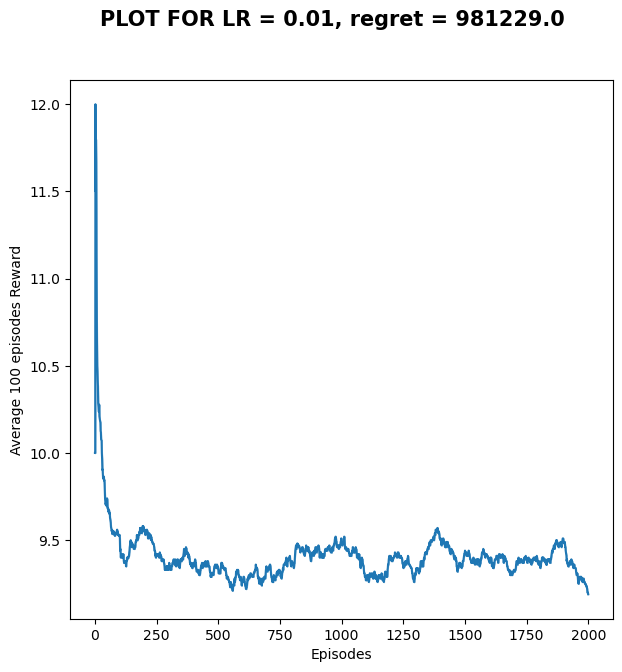

100%|██████████| 2000/2000 [04:14<00:00,  7.84it/s]


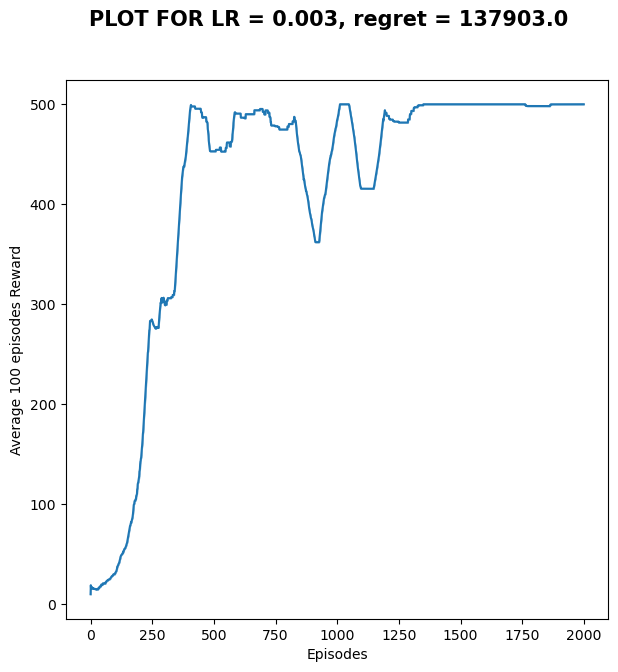

100%|██████████| 2000/2000 [03:43<00:00,  8.94it/s]


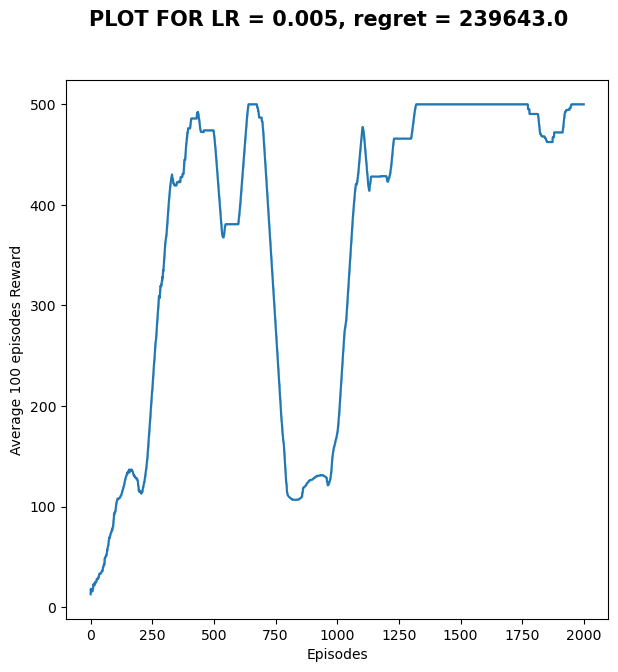

100%|██████████| 2000/2000 [02:41<00:00, 12.38it/s]


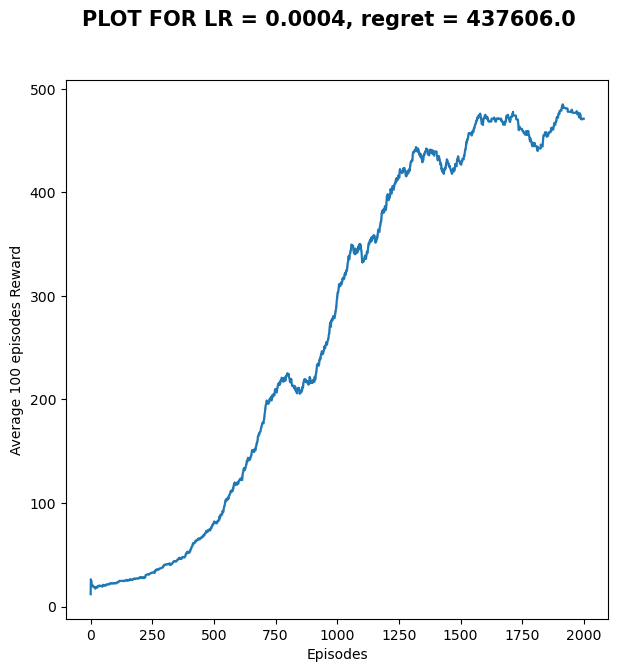

100%|██████████| 2000/2000 [03:23<00:00,  9.81it/s]


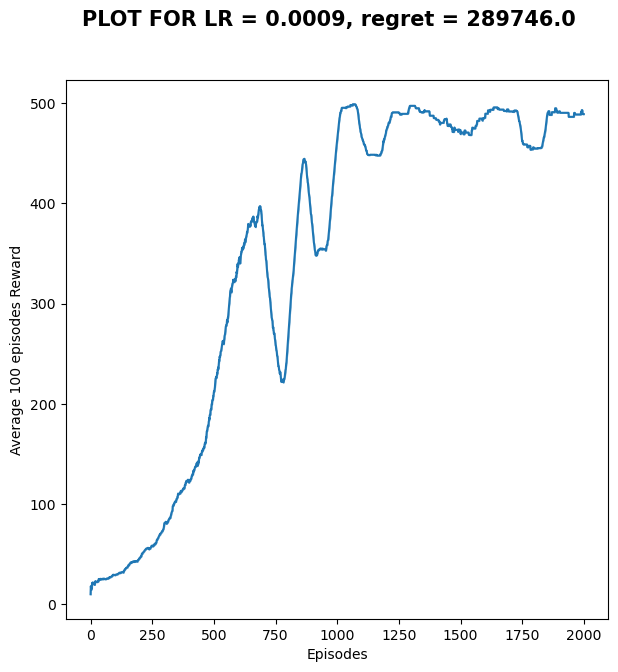

In [106]:
avg_G_seeds = []
for policy_lr in policy_lrs:
  random.seed(seed)

  PolicyNetwork = Policy(env.observation_space.shape[0], env.action_space.n, seed).to(device)

# Initialize optimizer
  policy_optimizer = optim.Adam(PolicyNetwork.parameters(), lr = policy_lr)

  scores_window = deque(maxlen=100)
  scores_ep = []
  scores = []

  for _ in tqdm(range(num_episodes)):
    state = env.reset()
    rewards = []
    log_probs = []
    score = 0

    for _ in range(max_steps):
      #env.render()

      action, log_p = choose_action(PolicyNetwork, state)

      next_state, reward, done, _ = env.step(action)

      score += reward

      rewards.append(reward)
      log_probs.append(log_p)

      if done:
        break

      state = next_state

    scores.append(score)
    scores_window.append(score)
    scores_ep.append(np.mean(scores_window))

    rewards = calculate_rewards(rewards)

    train_policy(rewards, log_probs, policy_optimizer)

  avg_G_seeds.append(scores_ep)
  reg = regret([scores])
  plot_f([scores_ep], f'PLOT FOR LR = {policy_lr}, regret = {reg[0]}')


  env.close()

In [66]:
policy_lrs = [4e-4, 9e-4,3e-3,1e-3]
state_val_lrs = [9e-3, 7e-3, 9e-2, 5e-3, 1e-2]
solved_score = 475



### **Training loop for REINFORCE with baseline**

100%|██████████| 2000/2000 [02:01<00:00, 16.52it/s]


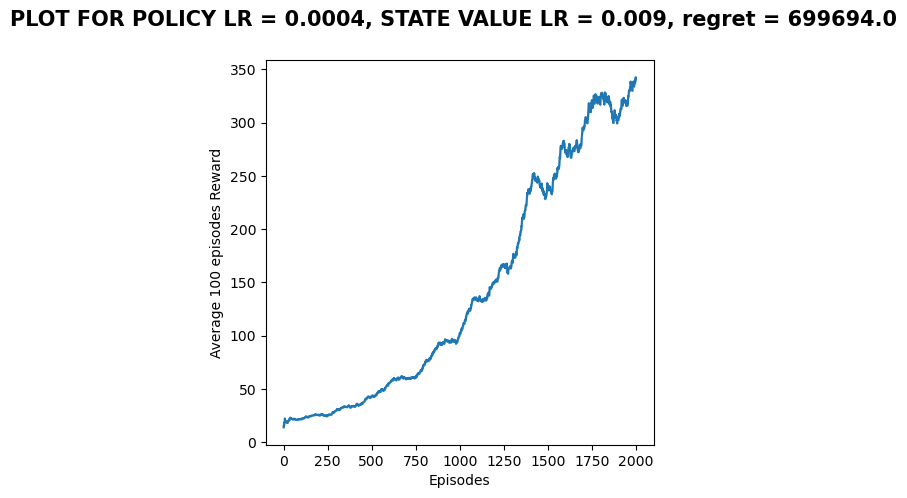

100%|██████████| 2000/2000 [02:33<00:00, 13.04it/s]


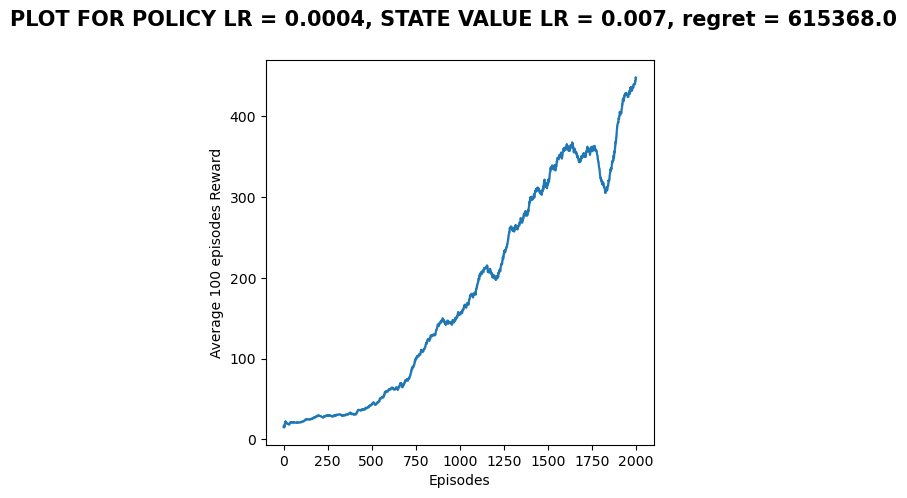

100%|██████████| 2000/2000 [02:25<00:00, 13.72it/s]


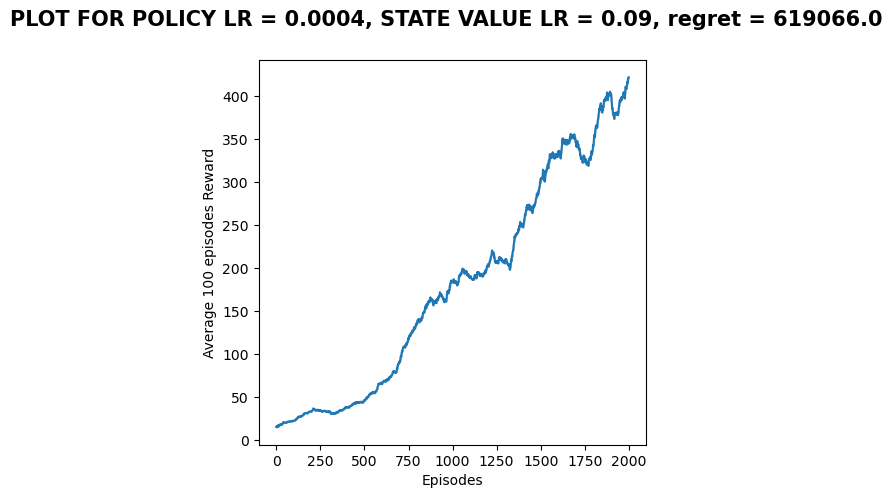

100%|██████████| 2000/2000 [02:32<00:00, 13.08it/s]


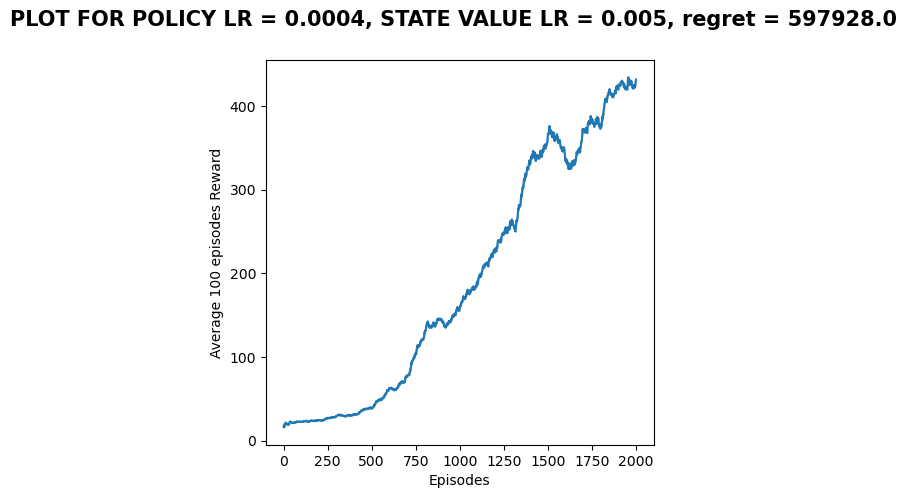

100%|██████████| 2000/2000 [02:27<00:00, 13.53it/s]


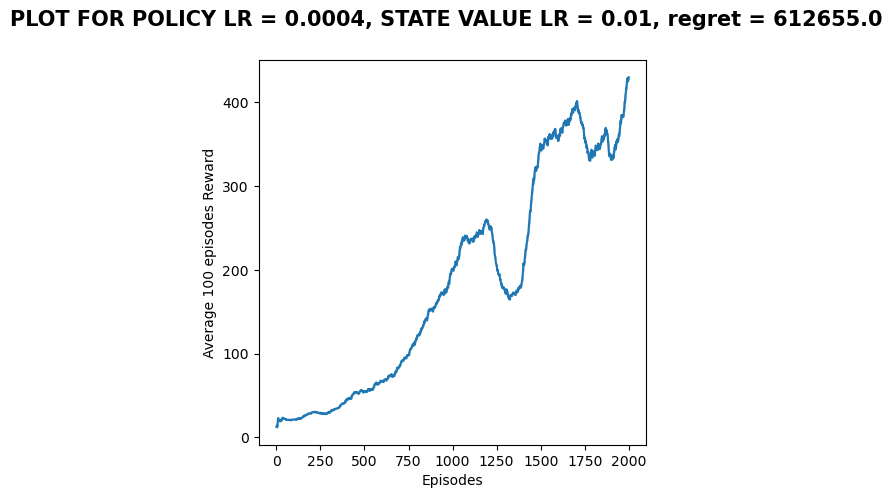

100%|██████████| 2000/2000 [04:30<00:00,  7.40it/s]


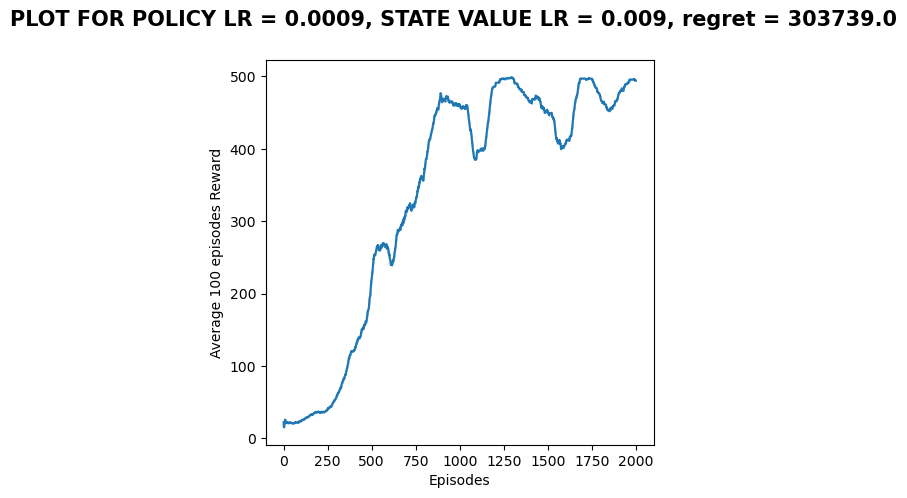

100%|██████████| 2000/2000 [04:14<00:00,  7.85it/s]


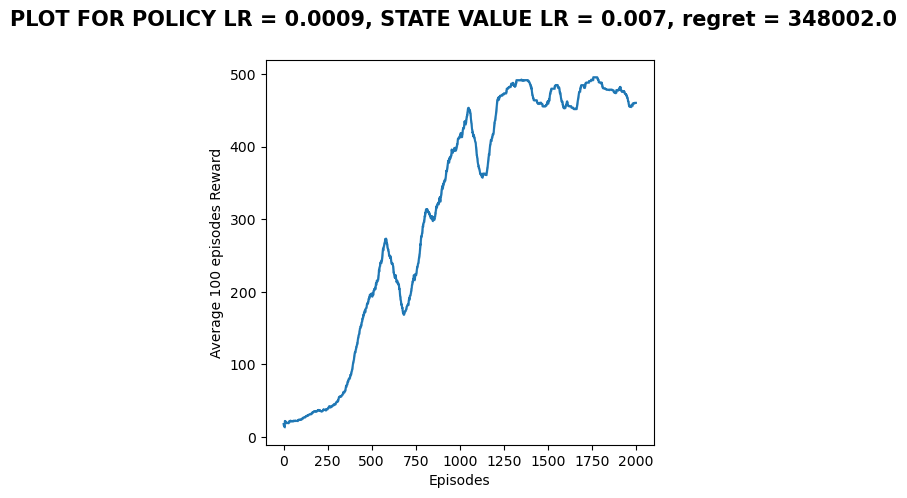

100%|██████████| 2000/2000 [04:16<00:00,  7.79it/s]


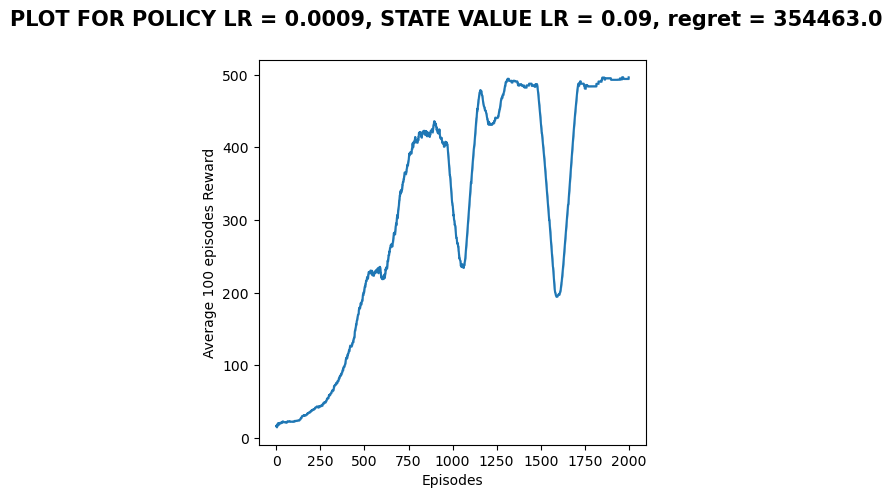

100%|██████████| 2000/2000 [04:35<00:00,  7.27it/s]


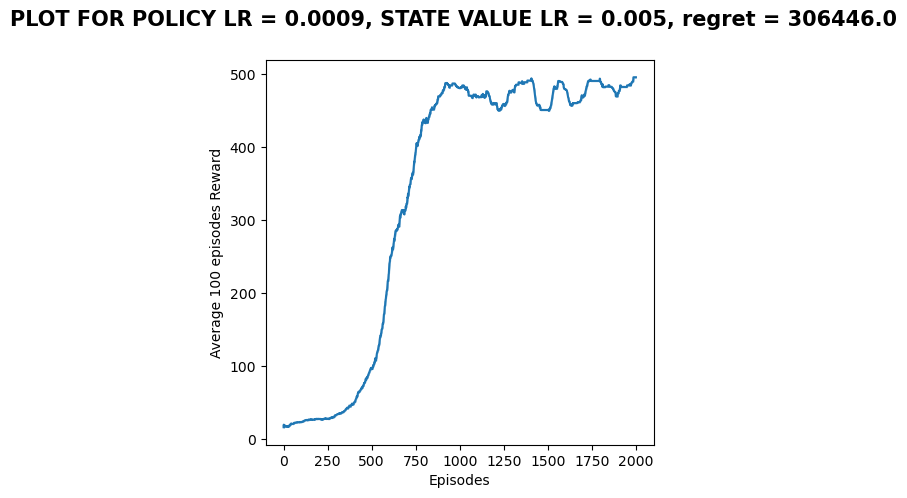

100%|██████████| 2000/2000 [03:24<00:00,  9.80it/s]


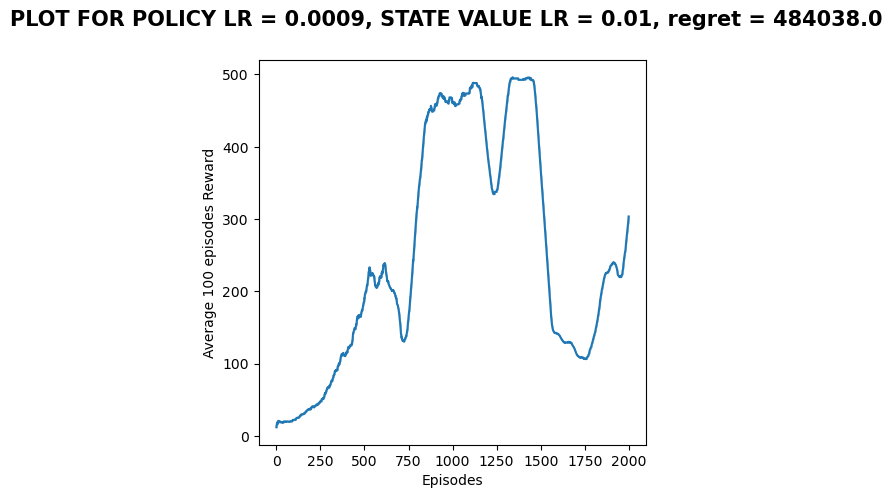

100%|██████████| 2000/2000 [05:14<00:00,  6.36it/s]


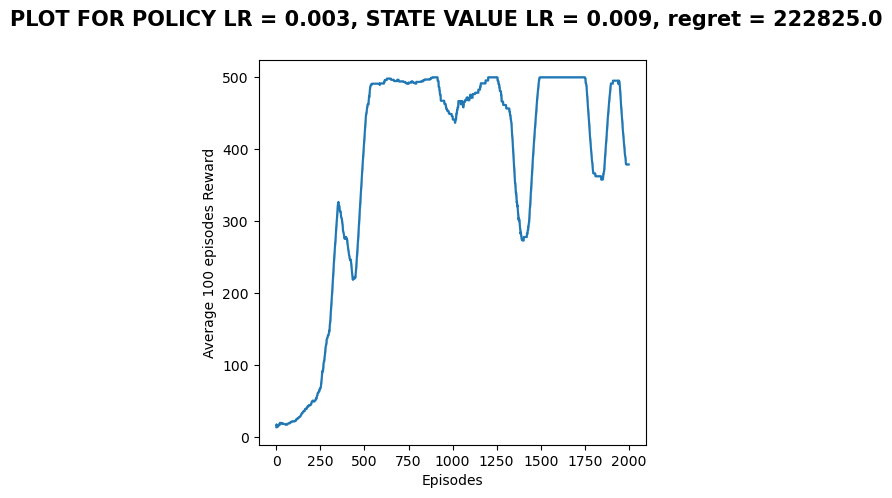

100%|██████████| 2000/2000 [04:37<00:00,  7.20it/s]


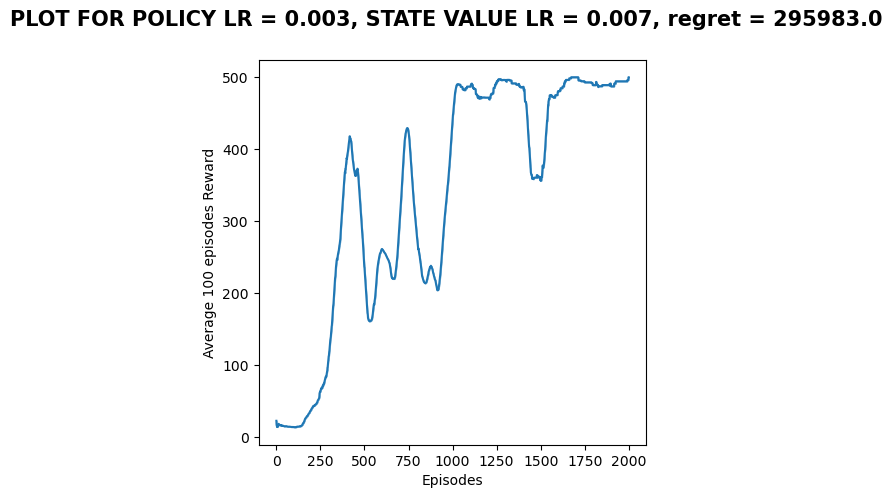

100%|██████████| 2000/2000 [02:48<00:00, 11.86it/s]


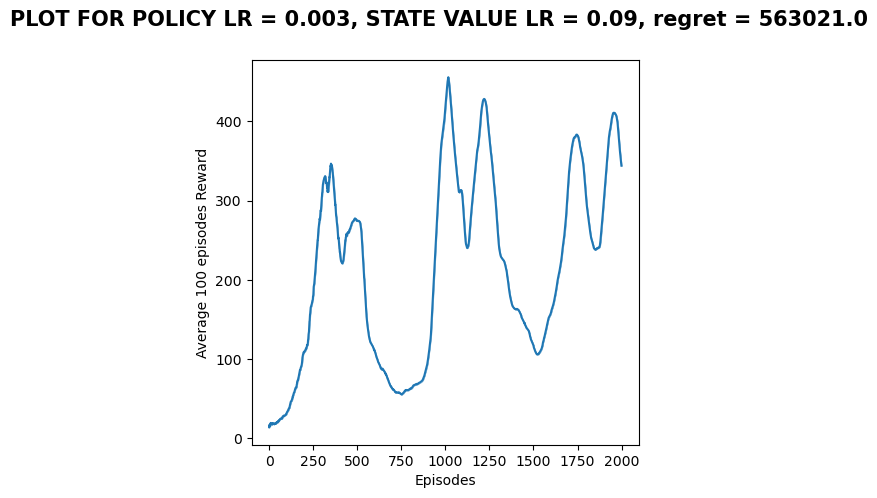

100%|██████████| 2000/2000 [05:09<00:00,  6.46it/s]


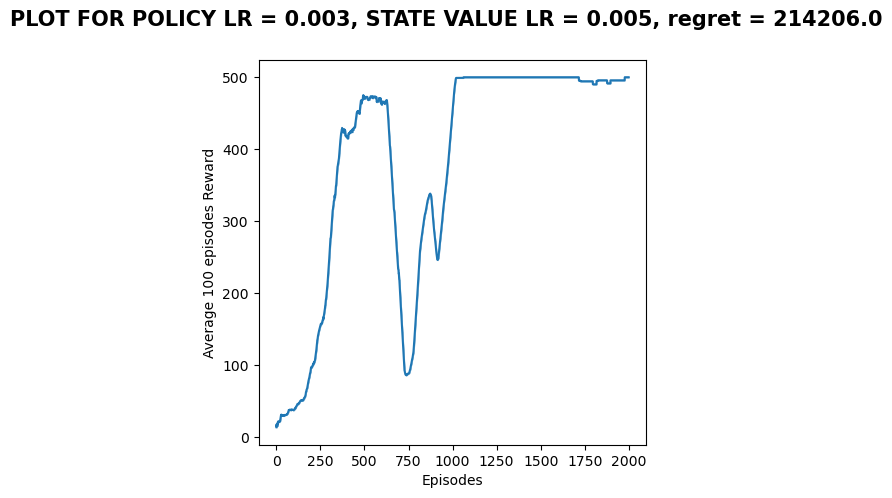

100%|██████████| 2000/2000 [04:29<00:00,  7.42it/s]


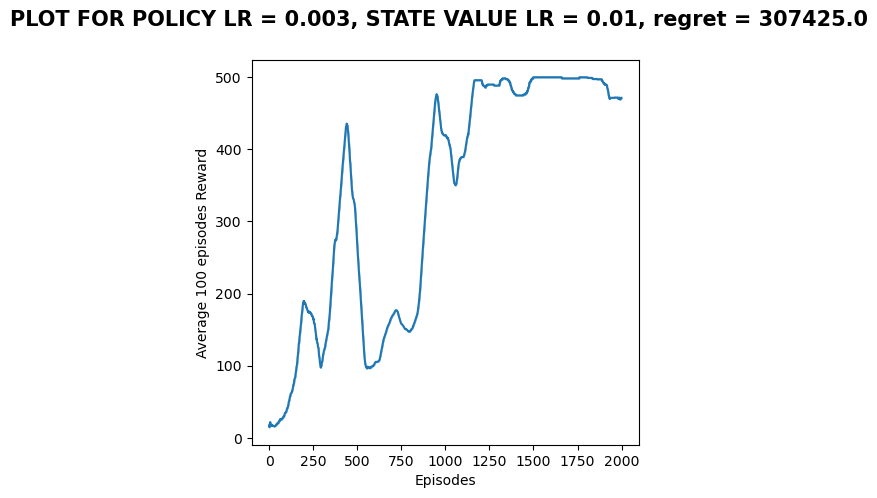

100%|██████████| 2000/2000 [03:25<00:00,  9.73it/s]


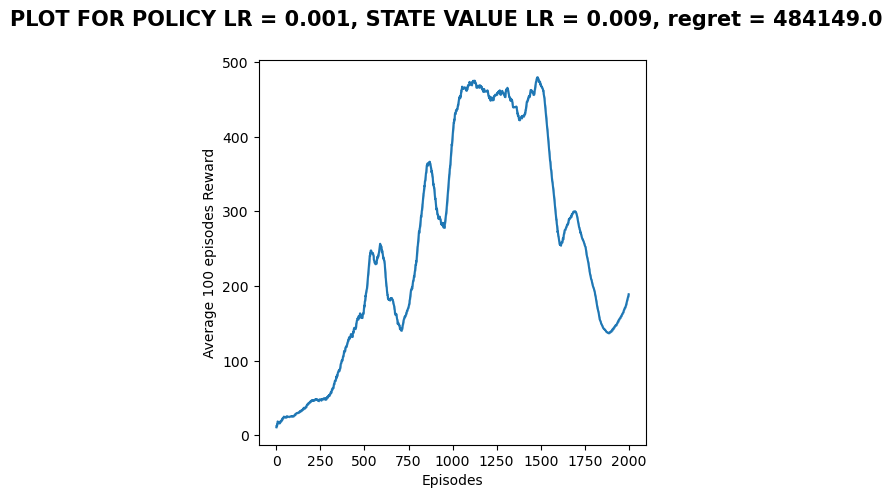

100%|██████████| 2000/2000 [04:30<00:00,  7.38it/s]


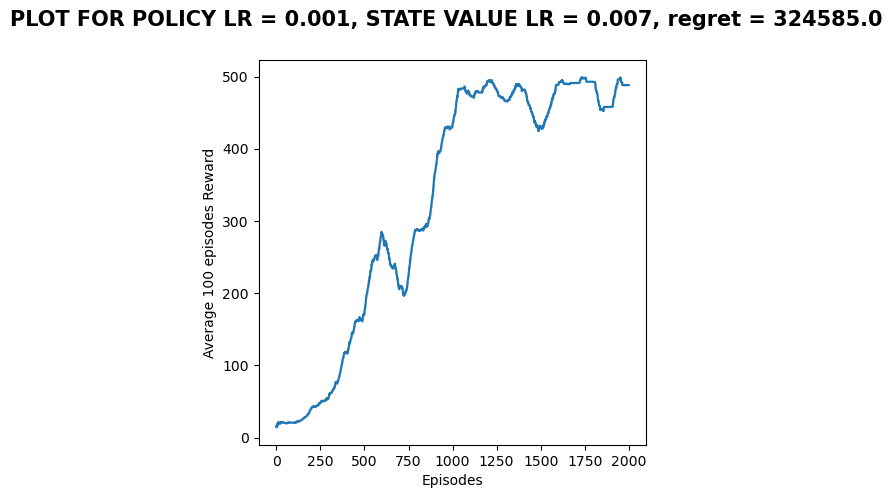

100%|██████████| 2000/2000 [02:57<00:00, 11.25it/s]


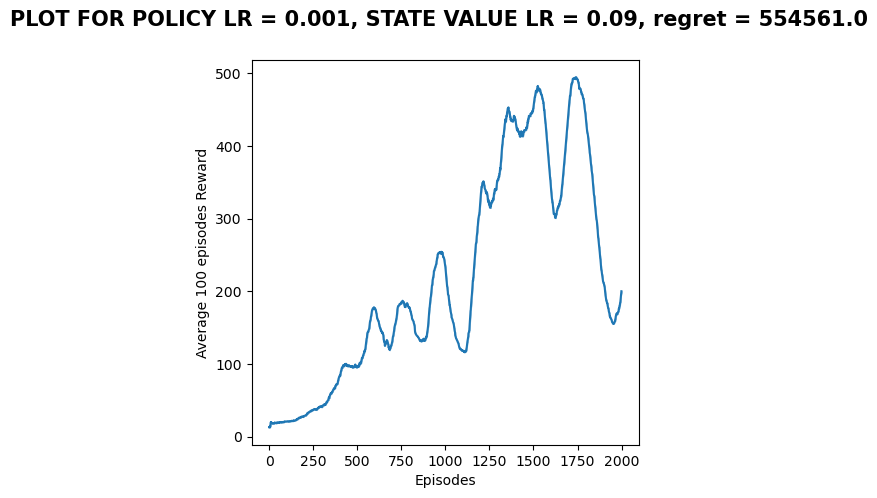

100%|██████████| 2000/2000 [04:13<00:00,  7.90it/s]


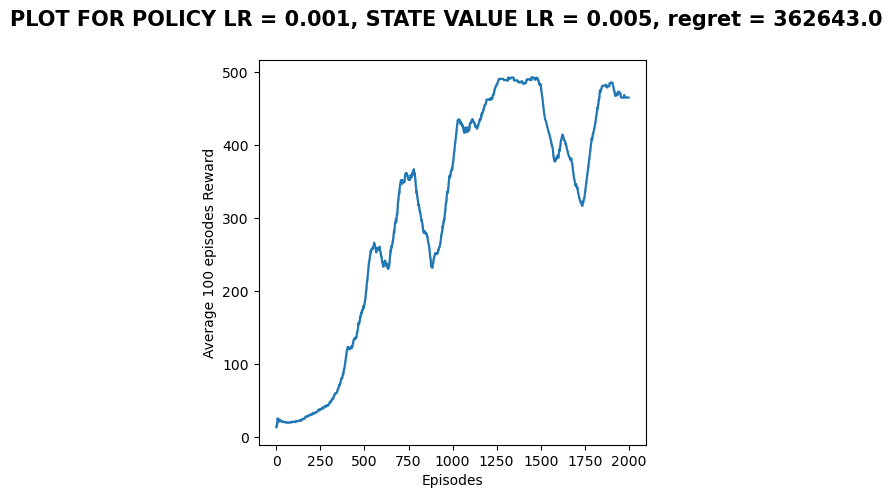

100%|██████████| 2000/2000 [04:50<00:00,  6.88it/s]


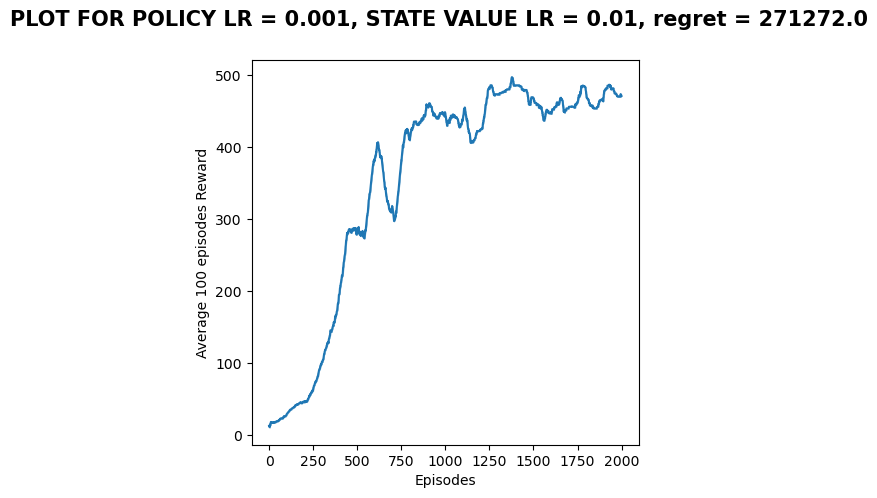

In [67]:
avg_G_seeds_bl = []
for policy_lr in policy_lrs:
  for state_val_lr in state_val_lrs:

    # print(env.observation_space.shape[0], env.action_space.n)
    random.seed(seed)

    # Initialize policy network
    PolicyNetwork = Policy(env.observation_space.shape[0], env.action_space.n, seed).to(device)
    State_val_Network = State_val(env.observation_space.shape[0], seed).to(device)

    # Initialize optimizer
    policy_optimizer = optim.Adam(PolicyNetwork.parameters(), lr = policy_lr)
    state_val_optimizer = optim.Adam(State_val_Network.parameters(), lr = state_val_lr)

    scores_window_bl = deque(maxlen=100)
    scores_ep_bl = []
    scores = []


    for _ in tqdm(range(num_episodes)):
      state = env.reset()
      rewards = []
      log_probs = []
      trajectory = []
      score = 0

      for _ in range(max_steps):
        #env.render()

        action, log_p = choose_action(PolicyNetwork, state)

        next_state, reward, done, _ = env.step(action)

        score += reward

        trajectory.append([state, action, reward, log_p])

        if done:
          break

        state = next_state


      scores.append(score)
      scores_window_bl.append(score)
      scores_ep_bl.append(np.mean(scores_window_bl))

      states = [t[0] for t in trajectory]
      actions = [t[1] for t in trajectory]
      rewards = [t[2] for t in trajectory]
      log_probs = [t[3] for t in trajectory]

      G_cumulative = calculate_rewards(rewards)

      state_values = []

      for state in states:
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        state_values.append(State_val_Network(state))

      state_values = torch.stack(state_values).squeeze()

      train_state_val(G_cumulative, state_values, state_val_optimizer)

      delta_values = [G - b for G, b in zip(G_cumulative, state_values)]
      delta_values = torch.tensor(delta_values).to(device)

      train_policy(delta_values, log_probs, policy_optimizer)

    avg_G_seeds_bl.append(scores_ep_bl)
    reg = regret([scores])
    plot_f([scores_ep_bl], f'PLOT FOR POLICY LR = {policy_lr}, STATE VALUE LR = {state_val_lr}, regret = {reg[0]}')

    env.close()

In [141]:
seeds = [5, 42, 12, 9, 134]
# Best policy learning rate for REINFORCE without baseline
policy_lr = 3e-3
    

### **REINFORCE: Average over seeds for best learning rate**

In [144]:
avg_G_seeds = []
for seed in seeds:
  env = gym.make('Acrobot-v1')
  env.seed(seed)

  PolicyNetwork = Policy(env.observation_space.shape[0], env.action_space.n, seed = 0).to(device)

# Initialize optimizer
  policy_optimizer = optim.Adam(PolicyNetwork.parameters(), lr = policy_lr)

  scores_window = deque(maxlen=100)
  scores_ep = []
  scores = []

  for _ in tqdm(range(num_episodes)):
    state = env.reset()
    rewards = []
    log_probs = []
    score = 0

    for _ in range(max_steps):
      #env.render()

      action, log_p = choose_action(PolicyNetwork, state)

      next_state, reward, done, _ = env.step(action)

      score += reward

      rewards.append(reward)
      log_probs.append(log_p)

      if done:
        break

      state = next_state

    scores.append(score)
    scores_window.append(score)
    scores_ep.append(np.mean(scores_window))

    rewards = calculate_rewards(rewards)

    train_policy(rewards, log_probs, policy_optimizer)

  avg_G_seeds.append(scores_ep)
  #reg = regret([scores])
  #plot_f([scores_ep], f'PLOT FOR LR = {policy_lr}, regret = {reg[0]}')


  env.close()

  0%|          | 0/1250 [00:00<?, ?it/s]

100%|██████████| 1250/1250 [01:16<00:00, 16.38it/s]


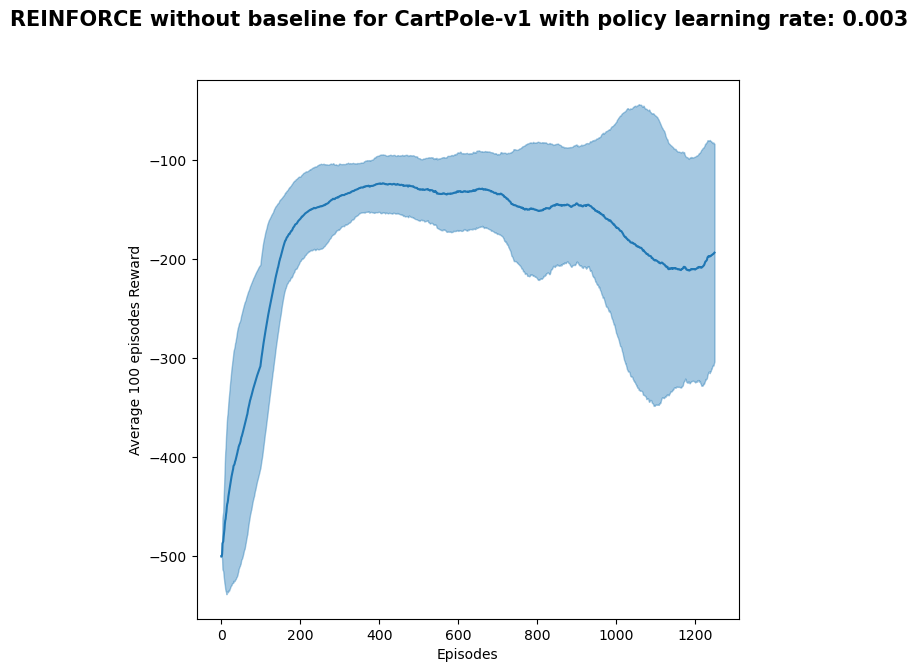

In [145]:
plot_f(avg_G_seeds, f'REINFORCE without baseline for CartPole-v1 with policy learning rate: {policy_lr}')

### **REINFORCE with baseline: Average over seeds for best learning rate**

In [134]:
seeds = [32, 56, 2, 90 ,11 ]
# Best hyperparameters based on minimum regret
policy_lr = 3e-3
state_val_lr = 5e-3

In [138]:
avg_G_seeds_bl = []
for seed in seeds:
  env = gym.make('Acrobot-v1')
  env.seed(seed)

  # Initialize policy network
  PolicyNetwork = Policy(env.observation_space.shape[0], env.action_space.n, seed=1).to(device)
  State_val_Network = State_val(env.observation_space.shape[0], seed=1).to(device)

  # Initialize optimizer
  policy_optimizer = optim.Adam(PolicyNetwork.parameters(), lr = policy_lr)
  state_val_optimizer = optim.Adam(State_val_Network.parameters(), lr = state_val_lr)

  scores_window_bl = deque(maxlen=100)
  scores_ep_bl = []
  scores = []


  for _ in tqdm(range(num_episodes)):
    state = env.reset()
    rewards = []
    log_probs = []
    trajectory = []
    score = 0

    for _ in range(max_steps):
      #env.render()

      action, log_p = choose_action(PolicyNetwork, state)

      next_state, reward, done, _ = env.step(action)

      score += reward

      trajectory.append([state, action, reward, log_p])

      if done:
        break

      state = next_state


    scores.append(score)
    scores_window_bl.append(score)
    scores_ep_bl.append(np.mean(scores_window_bl))

    states = [t[0] for t in trajectory]
    actions = [t[1] for t in trajectory]
    rewards = [t[2] for t in trajectory]
    log_probs = [t[3] for t in trajectory]

    G_cumulative = calculate_rewards(rewards)

    state_values = []

    for state in states:
      state = torch.from_numpy(state).float().unsqueeze(0).to(device)
      state_values.append(State_val_Network(state))

    state_values = torch.stack(state_values).squeeze()

    train_state_val(G_cumulative, state_values, state_val_optimizer)

    delta_values = [G - b for G, b in zip(G_cumulative, state_values)]
    delta_values = torch.tensor(delta_values).to(device)

    train_policy(delta_values, log_probs, policy_optimizer)

  avg_G_seeds_bl.append(scores_ep_bl)
  #reg = regret([scores])
  #plot_f([scores_ep_bl], f'PLOT FOR POLICY LR = {policy_lr}, STATE VALUE LR = {state_val_lr}, regret = {reg[0]}')

  env.close()

  0%|          | 0/1250 [00:00<?, ?it/s]

100%|██████████| 1250/1250 [01:03<00:00, 19.80it/s]


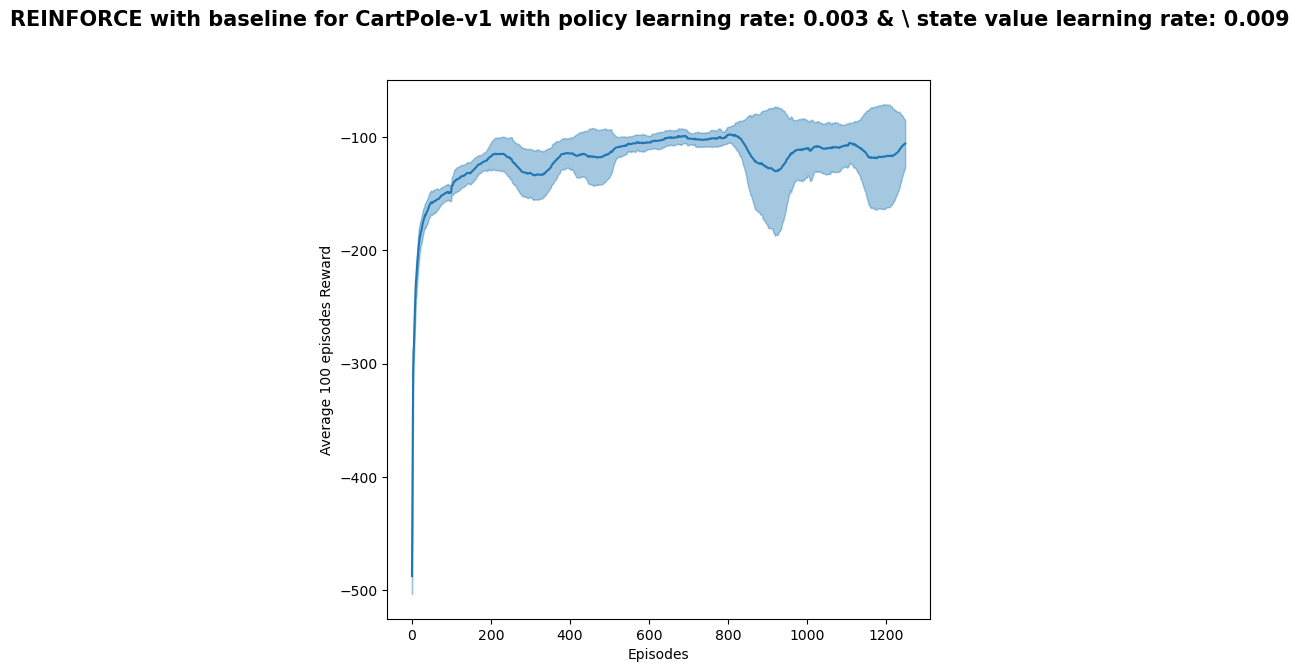

In [139]:
plot_f(avg_G_seeds_bl, f'REINFORCE with baseline for CartPole-v1 with policy learning rate: {policy_lr} & \\ state value learning rate: {state_val_lr}')

In [146]:
def plot_f(reward_avgs, reward_avgs_bl, msg='Reward Curve'):
  fig, ax = plt.subplots(figsize=(7, 7))
  fig.suptitle(msg, fontsize=15, weight='extra bold')

  mean_y = np.mean(reward_avgs, 0)
  std_y = np.std(reward_avgs, 0)
  ax.plot(range(0, len(reward_avgs[0])), np.average(reward_avgs, 0), label='w/o Baseline', color='#1f77b4')
  ax.fill_between(range(0, len(reward_avgs[0])), mean_y - std_y, mean_y + std_y, color='#1f77b4', alpha=0.2)

  mean_y_bl = np.mean(reward_avgs_bl, 0)
  std_y_bl = np.std(reward_avgs_bl, 0)
  ax.plot(range(0, len(reward_avgs_bl[0])), np.average(reward_avgs_bl, 0), label='w/ Baseline', color='#FF8C00')
  ax.fill_between(range(0, len(reward_avgs_bl[0])), mean_y_bl - std_y_bl, mean_y_bl + std_y_bl, color='#FF8C00', alpha=0.2)

  ax.set_xlabel('Episodes')
  ax.set_ylabel('Average 100 episodes Reward')
  ax.legend(loc='upper right',  bbox_to_anchor=(1, 0.8))
  plt.show()

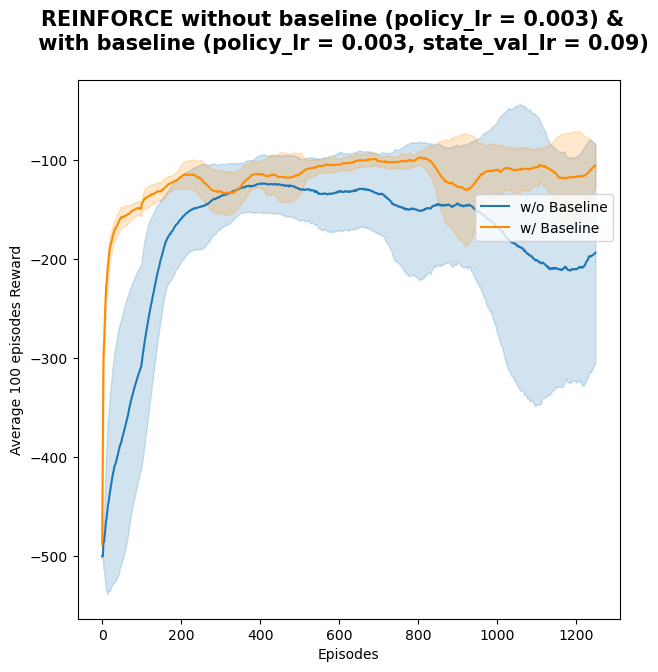

In [147]:
plot_f(avg_G_seeds, avg_G_seeds_bl, f'REINFORCE without baseline (policy_lr = 0.003) &  \n with baseline (policy_lr = 0.003, state_val_lr = 0.09)')